## Random Forests Project
In this project, we will be using a dataset containing census information from UCI’s Machine Learning Repository.

By using this census data with a random forest, we will try to predict whether or not a person makes more than $50,000.

Datasets
The original data set is available at the UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/census+income

Our input and output features of interest are:

- age: continuous
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: Female, Male
- capital-gain: continuous
- capital-loss: continuous
- hours-per-week: continuous
- native country: discrete
- income: discrete, >50K, <=50K

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']
df = pd.read_csv('adult.data', header=None, names = col_names)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### We will build a random forest classifier to predict the income category. 
1. First, take a look at the distribution of income values – what percentage of samples have incomes less than 50k and greater than 50k?

In [2]:
df.income.value_counts(normalize=True)

income
 <=50K    0.75919
 >50K     0.24081
Name: proportion, dtype: float64

There’s a small problem with our data that is a little hard to catch — every string has an extra space at the start. For example, the first row’s native-country is “ United-States”, but we want it to be “United-States”.

In [3]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()
df['native-country'].unique()    

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

2. Let us choose features from the list of interest to start

In [4]:
features_list = ['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']

3. Create a features dataframe X. This should include only features in the list feature_cols and convert categorical features to dummy variables.

In [5]:
X = pd.get_dummies(df[features_list], drop_first=True)
X.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,sex_Male,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,2174,0,40,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,50,0,0,13,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,True
2,38,0,0,40,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
3,53,0,0,40,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
4,28,0,0,40,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False


4. Create the output variable ***y***, which is binary. It should be 0 when income is less than 50k and 1 when it is greater than 50k.

In [6]:
y = (df.income == '<=50K')*1 
y.value_counts(normalize=True)

income
1    0.75919
0    0.24081
Name: proportion, dtype: float64

5. Split the data into a train and test set with a test size of 20%.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

6. Instantiate an instance of a RandomForestClassifier() (with default parameters). Fit the model on the train data and print the score (accuracy) on the test data. This will act as a baseline to compare other model performances.

In [8]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print("Accuracy of the Random Forest Classifier (default parameters):", rf.score(x_test, y_test))

Accuracy of the Random Forest Classifier (default parameters): 0.8421618301857823


7. We will explore tuning the random forest classifier model by testing the performance over a range of max_depth values from 1-25.

In [9]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
accuracy_train = []
accuracy_test = []
m_depths = range(1,26)
for depth in m_depths:
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(x_train, y_train)
    accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))
    accuracy_test.append(accuracy_score(y_test, rf.predict(x_test)))  

8. Find the largest accuracy and the depth this occurs on the test data.

In [10]:
best_accuracy = np.max(accuracy_test)
best_max_depth = m_depths[np.argmax(accuracy_test)]
print("Best accuracy score for max_depths from 1 to 25:", best_accuracy)
print("Best max_depths value for the best accuracy score:", best_max_depth)

Best accuracy score for max_depths from 1 to 25: 0.8635037617073545
Best max_depths value for the best accuracy score: 16


9. Plot the training and test accuracy of the models versus the max_depth.

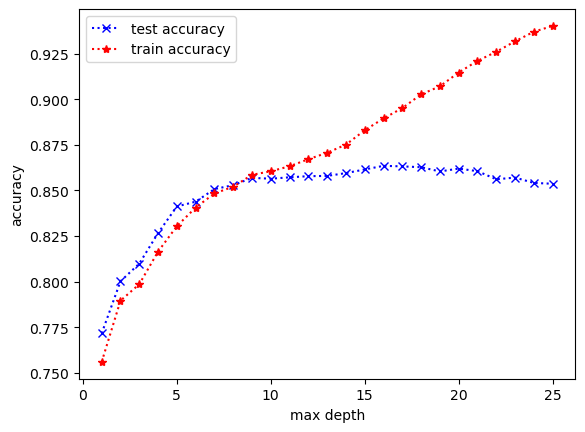

In [11]:
plt.plot(m_depths, accuracy_test,'bx:',m_depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

10. Refit the random forest model using the max_depth from above; save the feature importances in a dataframe. Sort the results and print the top ten features.

In [12]:
rf_best = RandomForestClassifier(max_depth=best_max_depth)
rf_best.fit(x_train, y_train)
feature_importances = pd.DataFrame(zip(x_train.columns, rf_best.feature_importances_),  columns=['feature', 'importance'])
print('Best 5 random forest features:')
print(feature_importances.sort_values('importance', ascending=False).iloc[0:10])

Best 5 random forest features:
                              feature  importance
1                        capital-gain    0.197219
13  marital-status_Married-civ-spouse    0.192065
0                                 age    0.138297
3                      hours-per-week    0.097108
2                        capital-loss    0.065327
15       marital-status_Never-married    0.058250
27          occupation_Prof-specialty    0.046342
21         occupation_Exec-managerial    0.045194
32                           sex_Male    0.033039
25           occupation_Other-service    0.014414


### Create Additional Features and Re-Tune

Let's add two features to our list **education** and **native-country**.
Looking at the education feature, there are 16 unique values – from preschool to professional school. Rather than adding dummy variables for each value, it makes sense to bin some of these values together.

11. While there are many ways to do this, we will take the approach of combining the values into 3 groups: High school and less, College to Bachelors and Masters and more. Create a new column in df for this new features called **education_bin**.

In [13]:
print(df.education.unique())
print(df['education-num'].unique())

['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


In [14]:
df['education_bin'] = pd.cut(df['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])
features_list.extend(['education_bin','native-country'])
                     

13. Now we recreate data variable X, split new dataset for our study and, as we did before, we will tune the random forest classifier model by testing the performance over a range of max_depth values from 1-25.

In [15]:
X = pd.get_dummies(df[features_list], drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

In [16]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
new_accuracy_train = []
new_accuracy_test = []
m_depths = range(1,26)
for depth in m_depths:
    rf = RandomForestClassifier(max_depth=depth)
    rf.fit(x_train, y_train)
    new_accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))
    new_accuracy_test.append(accuracy_score(y_test, rf.predict(x_test))) 
    
    

14.Find the largest accuracy and the depth this occurs on the test data. Compare the results from the previous model tuned.

In [17]:
best_new_accuracy = np.max(new_accuracy_test)
best_new_max_depth = m_depths[np.argmax(new_accuracy_test)]
print("Best new accuracy score for max_depths from 1 to 25:", best_new_accuracy)
print("Best new max_depths value for the best new accuracy score:", best_new_max_depth)

Best new accuracy score for max_depths from 1 to 25: 0.8701059419622293
Best new max_depths value for the best new accuracy score: 21


15. Plot the training and test accuracy of the models versus the max_depth. Compare the results from the previous model tuned.

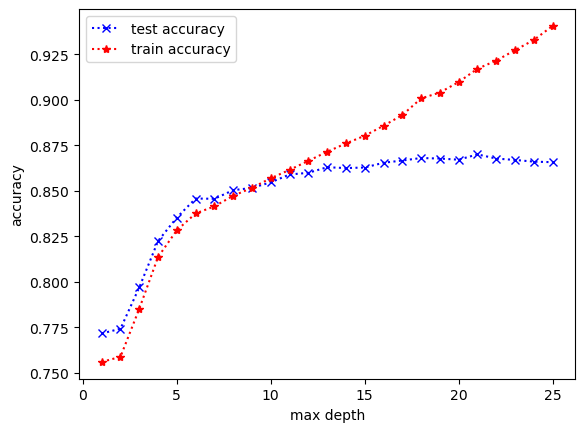

In [18]:
plt.clf()
plt.plot(m_depths, new_accuracy_test,'bx:',m_depths, new_accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

16. Refit the random forest model using the max_depth from above; save the feature importances in a dataframe. Sort the results and print the top ten features. Compare the results from the previous model tuned.

In [19]:
rf_new_best = RandomForestClassifier(max_depth=best_new_max_depth)
rf_new_best.fit(x_train, y_train)
new_features_importances = pd.DataFrame(zip(x_train.columns, rf_new_best.feature_importances_),  columns=['feature', 'importance'])
print('Best 5 random forest features (extended feature list):')
print(new_features_importances.sort_values('importance', ascending=False).iloc[0:10])

Best 5 random forest features (extended feature list):
                               feature  importance
13   marital-status_Married-civ-spouse    0.162802
1                         capital-gain    0.159801
0                                  age    0.145074
3                       hours-per-week    0.097435
15        marital-status_Never-married    0.055396
38       education_bin_Masters or more    0.053781
2                         capital-loss    0.051023
21          occupation_Exec-managerial    0.033866
32                            sex_Male    0.031086
37  education_bin_College to Bachelors    0.030622


### Conclusion
We can note that the accuracy of our final model increased and one of our added features is in the top 10 based on importance!

There are a few different ways to extend this project:

- Are there other features that may lead to an even better performace? Consider creating new ones or adding additional features not part of the original feature list.
- Consider tuning hyperparameters based on a different evaluation metric – our classes are fairly imbalanced, AUC of F1 may lead to a different result
- Tune more parameters of the model. For example, it is interesting what happens if we tune ***max_features*** or ***n_estimators***.